In [1]:
import copy
import math

import nbimporter
import nu

Importing Jupyter notebook from nu.ipynb


# 外皮性能に関する基準値の設定条件

## 1. 外皮性能に関する基準値の設定条件の概要

基準値計算のための条件設定の主な考え方は、以下のとおり。  

・外皮について、（極力）UA値、ηA値の基準値を満たすように、基準値計算用の住宅のU値（仕様規定の部位別U値に比例）と窓のη値を決定する。  
・基準値計算のための住宅モデルは、設計住戸の建て方（戸建／集合）、外皮面積、用途別床面積とする。ただし、外皮面積は下限値を設ける  
　それ以外の設計（例：階数、主方位）が変化しても熱負荷の基準値は変化させない。  
・非現実的な設定は許容しない（例：窓の日射熱取得率が0未満）。ただし、床・天井面積と壁面積の不整合は許容する。

## 2. 層構成の設定

### 1) 外皮の構成等の設定

#### Outline

各部位のU値より壁体構成を与える。

#### Class

In [2]:
class Material:
    
    def __init__( self, name, thick, cond, spech ):
        self.name   = name
        self.thick  = thick   # thickness, m
        self.cond   = cond    # thermal conductivity, W/mK
        self.spech  = spech   # volumetric specific heat, J/LK
    
    def R( self ):
        return self.thick / self.cond

#### Function

In [3]:
def convert_u_value_to_spec(structure, typeOfPart, U):
    # structure as string : wood, steel, rc, other
    # typeOfPart as string: ceiling, wall, floor, BoundaryCeiling, BoundaryWall, BoundaryFloor
    # U: heat transfer coefficient (W/m2K)
    s = structure
    t = typeOfPart
    R = 1 / U
    
    Ro, Ri = {
        'Ceiling'         : ( 0.040, 0.090 ),
        'Wall'            : ( 0.040, 0.110 ),
        'Floor'           : ( 0.040, 0.150 ),
        'BoundaryCeiling' : ( 0.090, 0.090 ),
        'BoundaryWall'    : ( 0.110, 0.110 ),
        'BoundaryFloor'   : ( 0.150, 0.150 ),
    }[t]
    
    mGypsum   = Material( name = 'GPB', thick = 0.0095, cond = 0.22, spech =  830.0 )
    mPlywood  = Material( name = 'PED', thick = 0.012,  cond = 0.16, spech =  720.0 )
    mConcrete = Material( name = 'RC',  thick = 0.120,  cond = 1.60, spech = 2000.0 )
    
    ins_name, ins_cond, ins_spech = 'GW16K', 0.045, 13.0
    
    def d( m ):
        return ( math.floor( max(0,( R -( Ro + m.R() + Ri )) * ins_cond ) * 1000 ) ) / 1000
    
    if ( s == 'Wood' or s == 'Steel' or s == 'Other' ):
        m = {
            'Ceiling'         : mGypsum,
            'Wall'            : mGypsum,
            'Floor'           : mPlywood,
            'BoundaryWall'    : mGypsum,
            'BoundaryFloor'   : mPlywood,
            'BoundaryCeiling' : mGypsum,
        }[t]
        Layer= [ Material( name = ins_name, thick = d(m), cond = ins_cond, spech = ins_spech ), m ]
    elif s == 'RC':
        m = mConcrete
        Layer= [ m, Material( name = ins_name, thick = d(m), cond = ins_cond, spech = ins_spech ) ]    
    else:
        raise ValueError
        
    return Layer

### 2) 内壁等の構成等の設定

#### Outline

内壁構成

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.090 | 0 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| 非密閉空気層 |  |  | 0.090 | 0 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| Ri | - | - | 0.090 | 0 |

#### Function

In [4]:
def get_innerwall( ) :

    return {
        'Name'      : 'Innerwall',
        'Type'      : 'InnerWall',
        'Direction' : 'Vertical',
        'Layers'    : [ 
            {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0125, 'SpecH': 830.0},
            {'Name': 'GPB', 'Cond': 1/0.09, 'Thick': 1, 'SpecH': 0},
            {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0125, 'SpecH': 830.0}
        ]
    }

## 3. 面積の設定

### 1) 用途別床面積を取得する関数

#### Outline

延床面積、主たる居室の床面積、その他の居室の床面積より、非居室の床面積を算出する。

#### Function

In [5]:
def get_area_floor( d ):
    return {
        'main': d['Common']['MainOccupantRoomFloorArea'],
        'other': d['Common']['OtherOccupantRoomFloorArea'],
        'nonliving': d['Common']['TotalFloorArea'] - d['Common']['MainOccupantRoomFloorArea'] - d['Common']['OtherOccupantRoomFloorArea']
    }

### 2) 総外皮面積に対する開口部比率、方位別の開口部比率

#### Outline

総外皮面積に対する開口部比率

| 建て方 | 総外皮面積に対する開口部比率 |
|---|---|
| 戸建 | 11％ |
| 共同 | 7％ |

方位別の開口部比率

| 建て方 | 北 | 南 | 東 | 西 |
|---|---|---|---|---|
| 戸建 | 11.0％ | 68.6％ | 13.2％ | 7.2％ |
| 共同 | 21.5％ | 63.3％ | 0.0％ | 15.2％ |

#### Function

In [6]:
# 開口部比率, -
def get_ratio_window( HouseType ) :
    
    ratio_window ={
        'detached': {
            'total': 0.11, 
            'direction':{ 'Top':0.000, 'N':0.110, 'S':0.686, 'E':0.132, 'W':0.072 }
        }, 
        'condominium': { 
            'total': 0.07, 
            'direction':{ 'Top':0.000, 'N':0.215, 'S':0.633, 'E':0.000, 'W':0.152 }
        }
    }
    
    return ratio_window[HouseType]

### 3) 方位別の開口部面積の設定

#### Outline

総外皮面積、相外皮面積に対する開口部比率、方位別の開口部比率より、方位別の開口部面積を設定する。  
ただし、ここで設定するのは暫定値であり、建て方別に、各方位の外皮面積を上限とした調整を行う。

$$
\displaystyle
A_w= A_{total} \times r_w
$$

$$
\displaystyle
A_{w,j}= A_w \times r_{w,j}
$$

$r_{w}$: 総外皮面積に対する開口部比率, -  
$r_{w,j}$: 方位jの開口部比率, -  
$A_{w}$: 開口部面積, m<sup>2</sup>  
$A_{w,j}$: 方位jの開口部面積, m<sup>2</sup>  
$A_{total}$: 総外皮面積, m<sup>2</sup>  

#### Function

In [7]:
def get_area_windows( HouseType, area_total_skin ) :

    # 開口部比率, -
    ratio_window = get_ratio_window( HouseType )
    
    # 開口部面積, m
    area_window = ratio_window['total'] * area_total_skin
    area_windows = { x : area_window * ratio_window['direction'][x] for x in ratio_window['direction'].keys()}
    
    return area_windows

### 4) 方位別の開口部面積の調整

#### Outline

方位別の開口部面積について、各方位の外皮面積を上限とした調整を行う。  
開口部面積の大きい方位より順に、各方位の外皮面積を上回る開口部面積を割り付ける。

In [8]:
# 窓面積の調整
def adjust_window_area( area_windows_pre, priority ):

    area_adjust = 0
    area_windows = {}
    for i in range(0,5):
        area_windows[priority[i]['Direction']] = min( area_adjust + area_windows_pre[priority[i]['Direction']], priority[i]['AreaMax'] )
        area_adjust = max( 0, area_adjust + area_windows_pre[priority[i]['Direction']] - priority[i]['AreaMax'] )

    return area_windows

In [9]:
area_windows = {'S':10,'N':5,'E':18,'W':6,'Top':0}

area_windows = adjust_window_area( area_windows, 
                                  [{'Direction':'S','AreaMax':8},
                                   {'Direction':'E','AreaMax':8},
                                   {'Direction':'N','AreaMax':7},
                                   {'Direction':'W','AreaMax':7},
                                   {'Direction':'Top','AreaMax':10}] )
    
print( area_windows )

{'S': 8, 'E': 8, 'N': 7, 'W': 7, 'Top': 9}


### 5) 外壁・開口部・内壁のリスト作成

#### Outline

各部位の面積をもとに、外壁・開口部・内壁のリストを作成する。

#### Function1

外壁のリスト作成

In [10]:
def get_list_wall( area_Walls ) :

    correspondence = {
        'type':{ 'Ceiling':'Ceiling', 'Floor':'Floor', 'WallN':'Wall', 'WallS':'Wall', 'WallE':'Wall', 'WallW':'Wall' },
        'direction':{ 'Ceiling':'Top', 'Floor':'Bottom', 'WallN':'N', 'WallS':'S', 'WallE':'E', 'WallW':'W' }
    }
    
    d = []    
    for x in area_Walls.keys() :
        for y in area_Walls[x].keys() :
            if area_Walls[x][y] > 0 :
                d.append({
                    'name': x + '_' + y,
                    'area': area_Walls[x][y],
                    'space': y,
                    'type':correspondence['type'][x],
                    'direction':correspondence['direction'][x],
                    'structure': 'Wood'})
    
    return d

#### Function2

開口部のリスト作成

In [11]:
def get_list_window( area_Windows ) :
    
    d = []    
    for x in area_Windows.keys() :
        for y in area_Windows[x].keys() :
            if area_Windows[x][y] > 0 :
                d.append({
                    'name': x + '_' + y,
                    'area': area_Windows[x][y],
                    'space': y,
                    'type': 'Window',
                    'direction':x})
    return d

#### Function3

内壁のリスト作成

In [12]:
def get_list_innerwall( area_InnerWalls ) :
    
    d = []    
    for x in area_InnerWalls.keys() :
        if area_InnerWalls[x] > 0 :
            d.append({
                'name': 'InnerWall_' + x ,
                'area': area_InnerWalls[x],
                'space': x,
                'type': 'InnerWall'})

    return d

#### Function4

外壁・開口部・内壁のリストの統合

In [13]:
def get_list( area ) :
    
    d = {}
    d['Walls'] = get_list_wall( area['Walls'] )
    d['Windows'] = get_list_window( area['Windows'] )
    d['InnerWalls'] = get_list_innerwall( area['InnerWalls'] )
    
    return d

### 6) 基準値計算用の住宅の幾何形状の決定

#### Outline

戸建住宅、共同住宅別に階高、階数を設定し、総外皮面積と床面積が設計住戸と等しくなるような直方体の住宅の幾何形状を決定する。  
ただし、以下の場合には、調整を行う。  
　設計住戸の総外皮面積が比較的小さく、総外皮面積と床面積が設計住戸に等しいという条件を満たす幾何形状を決定できない場合  
　基準値計算用の住戸の平面のアスペクト比が上限値を超える場合

建物高を各階の階高の合計値とする。

$$
\displaystyle
h = \sum_{n}{h_n}
$$

$h$: 建物高, m  
$h_n$: $n$階の階高, m  
$n$: 階数, -  

基準値計算用の住宅の総外皮面積を、設計住戸の総外皮面積、もしくは、正方形プランを仮定した総外皮面積の大きい方とする。

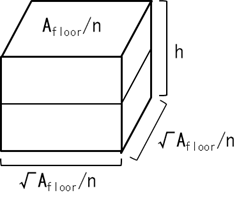

$$
\displaystyle
A_{total skin}= \max \left( A_{total skin,design}, \frac{ 2 \times A_{floor}}{ n } +  4 \times h \times　\sqrt{ \frac{ A_{floor} }{ n }} \right)
$$

$A_{floor}$: 延床皮面積, m<sup>2</sup>  
$A_{total skin}$: 基準値計算用の住宅の総外皮面積, m<sup>2</sup>  
$A_{total skin,design}$: 設計住戸の総外皮面積, m<sup>2</sup>  
$h$: 建物高, m  
$n$: 階数, -  

周長を、総外皮面積、延床面積、建物高、階数より算出する。  
短辺・長辺の長さを、周長、延床面積、階数、アスペクト比の上限値より算出する。

$$
\displaystyle
l_{circumference}= \frac{A_{totalskin}- 2 \times \frac{ A_{floor}}{ n }}{h}
$$
$$
\displaystyle
l_{narrow}= \max \left( \frac {l_{circumference}}{ 2 \times (1+r_{aspect,max})}, \frac{l_{circumference} - \sqrt{l_{circumference}^2 - 16 \times \frac{ A_{floor} }{ n }}}{4} \right)
$$
$$
\displaystyle
l_{long}= \frac{l_{circumference} - 2 \times l_{narrow}}{2}
$$

$l_{circumference}$: 周長, m  
$l_{narrow}$: 短辺長さ, m  
$l_{long}$: 長辺長さ, m  
$A_{floor}$: 延床皮面積, m<sup>2</sup>  
$A_{total skin}$: 基準値計算用の住宅の総外皮面積, m<sup>2</sup>  
$r_{aspect,max}$: アスペクト比の上限値（2とする）, -  
$n$: 階数, -  

アスペクト比を上限値により調整している場合に、面積算出用の床面積の調整を行うため、調整係数を算出する。

$$
\displaystyle
r_{area,floor}= \frac{ n \times l_{narrow} \times l_{long} }{ A_{floor} }
$$

$l_{narrow}$: 短辺長さ, m  
$l_{long}$: 長辺長さ, m  
$A_{floor}$: 延床皮面積, m<sup>2</sup>  
$n$: 階数, -  
$r_{area,floor}$: アスペクト比を上限値により調整している場合に、面積算出用の床面積の調整を行うための調整係数, -  

#### Function

In [14]:
def get_geometry(d, area_floor) :
    
    # 階高の設定
    floor_height ={ 'detached' : [ 2.9, 2.7 ], 'condominium' : [ 2.8 ] }[d['Common']['HouseType']]
    
    # 階数の設定
    n = { 'detached': 2, 'condominium': 1 }[d['Common']['HouseType']]
        
    # 建物高の算出
    height=sum( x for x in floor_height )
    
    # 基準住戸の総外皮面積の算出
    area_total_skin_min=2*(d['Common']['TotalFloorArea']/n)+4*height*(d['Common']['TotalFloorArea']/n)**0.5
    area_total_skin=max( area_total_skin_min, d['Common']['TotalOuterSkinArea'] )
    
    # 周長の算出
    length_circumference=(area_total_skin-(2*d['Common']['TotalFloorArea']/n))/height
    
    # アスペクト比の上限値の設定    
    ratio_aspect_max=2
    
    # 短辺・長辺長さの算出
    length_narrow=max(length_circumference/((1+ratio_aspect_max)*2),
                      (length_circumference-max( 0, length_circumference**2-16*d['Common']['TotalFloorArea']/n )**0.5)/4)
    length_long=(length_circumference-length_narrow*2)/2
    
    # アスペクト比を上限値により調整している場合、面積算出用の床面積の調整
    area_floor_r = { x : (area_floor[x] * length_narrow * length_long * n / d['Common']['TotalFloorArea']) for x in area_floor.keys()}

    return n, height, floor_height, area_total_skin, length_narrow, length_long, area_floor_r

### 7) 戸建住宅の面積の算出

#### Outline

戸建住宅の各部位の面積を、以下の場合に応じて、算出する。  
　主たる居室とその他の居室の床面積が等しい場合：北側を非居室、南側の1階を主たる居室、2階をその他の居室とする  
　主たる居室の床面積がその他の居室の床面積より大きい場合：北側を非居室、2階の南西をその他の居室とする  
　主たる居室の床面積がその他の居室の床面積より小さい場合：北側を非居室、1階の南東を主たる居室とする  

#### Function1

主たる居室とその他の居室の床面積が等しい場合：南側の1階を主たる居室、2階をその他の居室とする

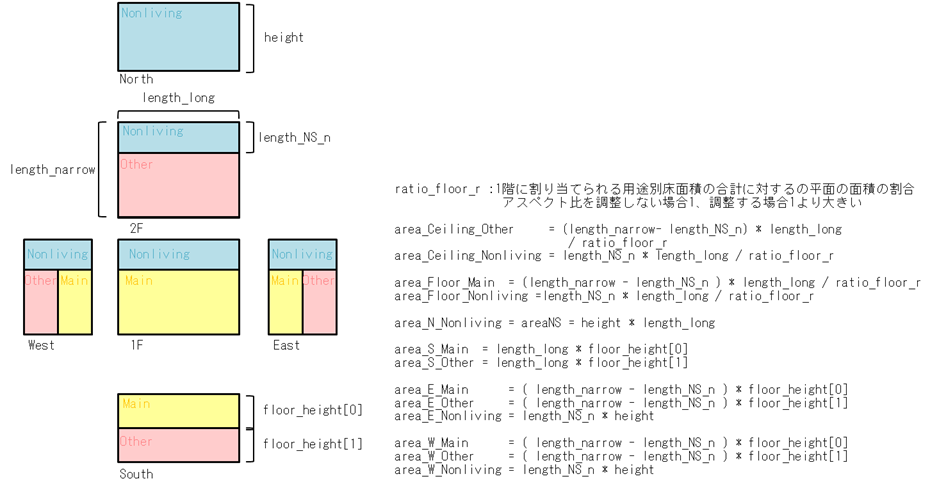

In [15]:
# 戸建住宅の面積算出
# 南側1階主たる居室、2階その他の居室
def get_area_detached_main_equal_to_other ( area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
                                            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows ) :

    area={}
    
    # 窓面積
    # 北窓は非居室
    # 南窓は1階主たる居室、南側2階その他の居室
    # 東窓・西窓は北側非居室、南側1階主たる居室、2階その他の居室
    area['Windows']={
        'N' : {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_windows['N']
        },
        'S' : {
            'main'      : area_windows['S'] * ratio_floor_height[0] ,
            'other'     : area_windows['S'] * ratio_floor_height[1] ,
            'nonliving' : 0
        },
        'E' : {
            'main'      : area_windows['E'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[0] ,
            'other'     : area_windows['E'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[1] ,
            'nonliving' : area_windows['E'] * ratio_length_NS_n
        },
        'W' : {
            'main'      : area_windows['W'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[0] ,
            'other'     : area_windows['W'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[1] ,
            'nonliving' : area_windows['W'] * ratio_length_NS_n
        },
        'Top' : {
            'main'      : 0,
            'other'     : area_windows['Top'] * ( 1 - ratio_length_NS_n ),
            'nonliving' : area_windows['Top'] * ratio_length_NS_n
        }
    }

    # 外壁面積
    area['Walls']={
        'Ceiling' : {
            'main'      : 0,
            'other'     : (length_narrow - length_NS_n) * length_long / ratio_floor_r - area['Windows']['Top']['other'],
            'nonliving' : length_NS_n * length_long / ratio_floor_r - area['Windows']['Top']['nonliving']
        },
        'Floor' : {
            'main'      : (length_narrow - length_NS_n) * length_long / ratio_floor_r,
            'other'     : 0,
            'nonliving' : length_NS_n * length_long / ratio_floor_r
        },
        'WallN': {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_NS - area['Windows']['N']['nonliving']
        },
        'WallS': {
            'main'      : length_long * floor_height[0] - area['Windows']['S']['main'],
            'other'     : length_long * floor_height[1] - area['Windows']['S']['other'],
            'nonliving' : 0
        },
        'WallE': {
            'main'      : ( length_narrow - length_NS_n ) * floor_height[0] - area['Windows']['E']['main'],
            'other'     : ( length_narrow - length_NS_n ) * floor_height[1] - area['Windows']['E']['other'],
            'nonliving' : length_NS_n * height - area['Windows']['E']['nonliving']
        },
        'WallW': {
            'main'      : ( length_narrow - length_NS_n ) * floor_height[0] - area['Windows']['W']['main'],
            'other'     : ( length_narrow - length_NS_n ) * floor_height[1]- area['Windows']['W']['other'],
            'nonliving' : length_NS_n * height - area['Windows']['W']['nonliving']                    
        }
    }

    # 内壁面積
    area['InnerWalls']={
        'main to other'      : length_long * ( length_narrow - length_NS_n ) ,
        'main to lonliving'  : length_long * floor_height[0] ,
        'other to nonliving' : length_long * floor_height[1] 
    }

    return area

#### Function2

主たる居室の床面積がその他の居室の床面積より大きい場合：北側を非居室、2階の南西をその他の居室とする

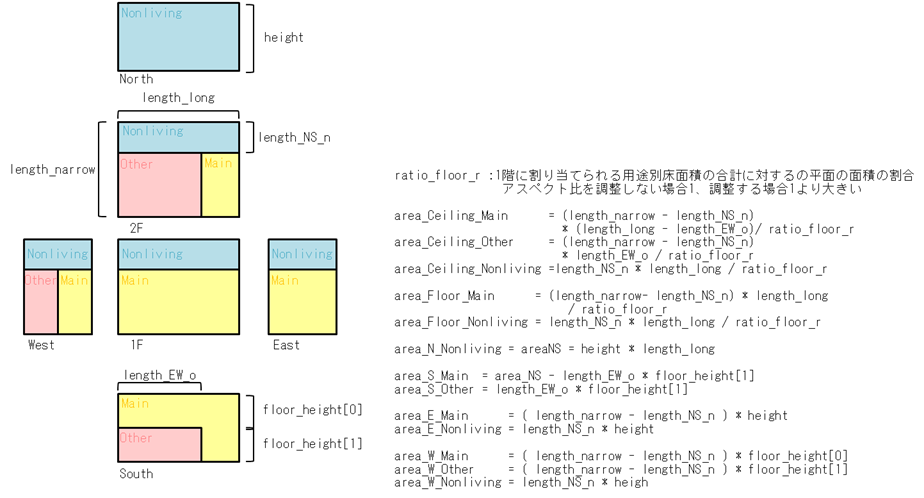

In [16]:
# 戸建住宅の面積算出
# 2階南西その他の居室
def get_area_detached_main_larger_than_other ( area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
                                            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows ) :
    
    length_EW_o= area_floor_r['other'] / ( length_narrow - length_NS_n )
 
    area={}
    
    # 窓面積
    # 北窓は非居室
    # 南窓は2階南西その他の居室、他は主たる居室、
    # 東窓は北側非居室、南側主たる居室
    # 西窓は北側非居室、南側1階主たる居室、南側2階その他の居室
    area['Windows']={
        'N' : {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_windows['N']
        },
        'S' : {
            'main'      : area_windows['S'] * (1 - length_EW_o * floor_height[1]/ area_NS) ,
            'other'     : area_windows['S'] * (length_EW_o * floor_height[1])/ area_NS ,
            'nonliving' : 0
        },
        'E' : {
            'main'      : area_windows['E'] * ( 1 - ratio_length_NS_n ),
            'other'     : 0,
            'nonliving' : area_windows['E'] * ratio_length_NS_n
        },
        'W' : {
            'main'      : area_windows['W'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[0] ,
            'other'     : area_windows['W'] *  ( 1 - ratio_length_NS_n ) * ratio_floor_height[1] ,
            'nonliving' : area_windows['W'] * ratio_length_NS_n
        },
        'Top' : {
            'main'      : area_windows['Top'] * ( 1 - ratio_length_NS_n ) * ( 1 - length_EW_o/length_long ),
            'other'     : area_windows['Top'] * ( 1 - ratio_length_NS_n ) * ( length_EW_o/length_long ),
            'nonliving' : area_windows['Top'] * ratio_length_NS_n
        }
    }

    # 外壁面積
    area['Walls']={
        'Ceiling' : {
            'main'      : (length_narrow - length_NS_n) * (length_long - length_EW_o) / ratio_floor_r - area['Windows']['Top']['main'],
            'other'     : (length_narrow - length_NS_n) * length_EW_o / ratio_floor_r - area['Windows']['Top']['other'],
            'nonliving' : length_NS_n * length_long / ratio_floor_r - area['Windows']['Top']['nonliving']
        },
        'Floor' : {
            'main'      : (length_narrow - length_NS_n) * length_long / ratio_floor_r,
            'other'     : 0,
            'nonliving' : length_NS_n * length_long / ratio_floor_r
        },
        'WallN': {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_NS - area['Windows']['N']['nonliving']
        },
        'WallS': {
            'main'      : (area_NS - length_EW_o * floor_height[1]) - area['Windows']['S']['main'],
            'other'     : length_EW_o * floor_height[1] - area['Windows']['S']['other'],
            'nonliving' : 0
        },
        'WallE': {
            'main'      : ( length_narrow - length_NS_n ) * height - area['Windows']['E']['main'],
            'other'     : 0,
            'nonliving' : length_NS_n * height - area['Windows']['E']['nonliving']
        },
        'WallW': {
            'main'      : ( length_narrow - length_NS_n ) * floor_height[0] - area['Windows']['W']['main'],
            'other'     : ( length_narrow - length_NS_n ) * floor_height[1]- area['Windows']['W']['other'],
            'nonliving' : length_NS_n * height - area['Windows']['W']['nonliving']                    
        }
    }

    # 内壁面積
    area['InnerWalls']={
        'main to other'      : ( length_narrow - length_NS_n ) * floor_height[1] + ( length_narrow - length_NS_n ) * length_EW_o ,
        'main to lonliving'  : area_NS - length_EW_o * floor_height[1] ,
        'other to nonliving' : length_EW_o * floor_height[1] 
    }

    return area

#### Function3

主たる居室の床面積がその他の居室の床面積より小さい場合：北側を非居室、1階の南東を主たる居室とする

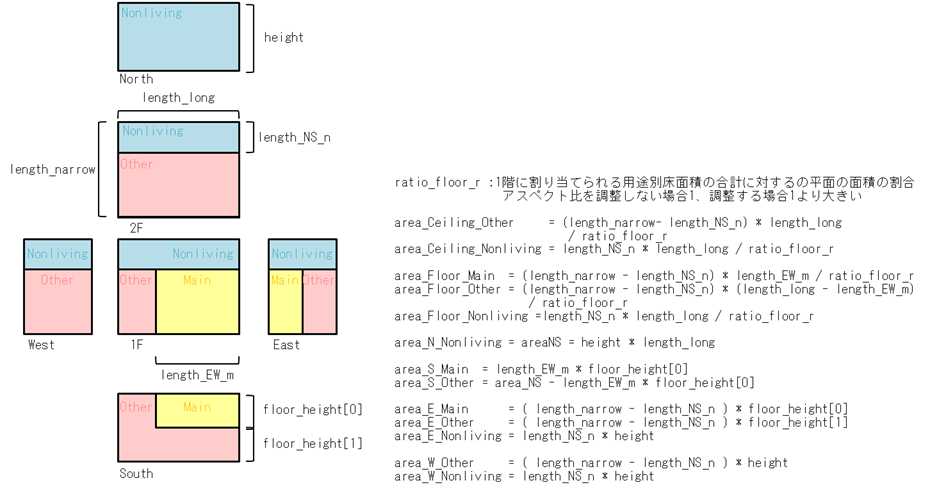

In [17]:
# 戸建住宅の面積算出
# 1階南東主たる居室
def get_area_detached_main_smaller_than_other ( area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
                                            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows ) :
    
    length_EW_m= area_floor_r['main'] / ( length_narrow - length_NS_n )
 
    area={}
    
    # 窓面積
    # 北窓は非居室
    # 南窓は1階南東主たる居室、他はその他の居室、
    # 東窓は北側非居室、南側1階主たる居室、南側2階その他の居室
    # 西窓は北側非居室、南側その他の居室
    area['Windows']={
        'N' : {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_windows['N']
        },
        'S' : {
            'main'      : area_windows['S'] * (length_EW_m * floor_height[0])/ area_NS ,
            'other'     : area_windows['S'] * (1 - length_EW_m * floor_height[0]/ area_NS) ,
            'nonliving' : 0
        },
        'E' : {
            'main'      : area_windows['E'] * ( 1 - ratio_length_NS_n ) * ratio_floor_height[0] ,
            'other'     : area_windows['E'] *  ( 1 - ratio_length_NS_n ) * ratio_floor_height[1] ,
            'nonliving' : area_windows['E'] * ratio_length_NS_n
        },
        'W' : {
            'main'      : 0,
            'other'     : area_windows['W'] * ( 1 - ratio_length_NS_n ),
            'nonliving' : area_windows['W'] * ratio_length_NS_n
        },
        'Top' : {
            'main'      : 0,
            'other'     : area_windows['Top'] * ( 1 - ratio_length_NS_n ),
            'nonliving' : area_windows['Top'] * ratio_length_NS_n
        }
    }

    # 外壁面積
    area['Walls']={
        'Ceiling' : {
            'main'      : 0,
            'other'     : (length_narrow - length_NS_n) * length_long / ratio_floor_r - area['Windows']['Top']['other'],
            'nonliving' :length_NS_n * length_long / ratio_floor_r - area['Windows']['Top']['nonliving']
        },
        'Floor' : {
            'main'      : (length_narrow - length_NS_n) * length_EW_m / ratio_floor_r,
            'other'     : (length_narrow - length_NS_n) * (length_long - length_EW_m) / ratio_floor_r,
            'nonliving' : length_NS_n * length_long / ratio_floor_r
        },
        'WallN': {
            'main'      : 0,
            'other'     : 0,
            'nonliving' : area_NS - area['Windows']['N']['nonliving']
        },
        'WallS': {
            'main'      : length_EW_m * floor_height[0] - area['Windows']['S']['main'],
            'other'     : (area_NS - length_EW_m * floor_height[0]) - area['Windows']['S']['other'],
            'nonliving' : 0
        },
        'WallE': {
            'main'      : ( length_narrow - length_NS_n ) * floor_height[0] - area['Windows']['E']['main'],
            'other'     : ( length_narrow - length_NS_n ) * floor_height[1]- area['Windows']['E']['other'],
            'nonliving' : length_NS_n * height - area['Windows']['E']['nonliving']
        },
        'WallW': {
            'main'      : 0,
            'other'     : ( length_narrow - length_NS_n ) * height - area['Windows']['W']['other'],
            'nonliving' : length_NS_n * height - area['Windows']['W']['nonliving']                    
        }
    }

    # 内壁面積
    area['InnerWalls']={
        'main to other'      : ( length_narrow - length_NS_n ) * floor_height[0] + ( length_narrow - length_NS_n ) * length_EW_m ,
        'main to lonliving'  : length_EW_m * floor_height[0] ,
        'other to nonliving' : area_NS - length_EW_m * floor_height[0] 
    }

    return area

#### Function4

方位別開口部面積が各方位の外皮面積を超過する場合、南、東、北、西、天井の順に、各方位の外皮面積を上限として、開口部面積を割り付ける。

戸建住宅の各部位の面積を、以下の場合に応じて、算出する。  
　主たる居室とその他の居室の床面積が等しい場合：北側を非居室、南側の1階を主たる居室、2階をその他の居室とする  
　主たる居室の床面積がその他の居室の床面積より大きい場合：北側を非居室、2階の南西をその他の居室とする  
　主たる居室の床面積がその他の居室の床面積より小さい場合：北側を非居室、1階の南東を主たる居室とする  

In [18]:
# 戸建住宅の面積算出
def get_area_detached( area_floor_total, area_floor, area_floor_r, n, height, floor_height, length_long, length_narrow, area_windows) :
    
    # 延床面積に対する用途別床面積の割合
    ratio_floor = { x : area_floor[x] / area_floor_total for x in area_floor.keys()}
 
    # アスペクト比を上限値により調整している場合、調整前の床面積に対する調整後の床面積の割合
    ratio_floor_r = sum( area_floor_r[x] for x in area_floor_r ) / sum( area_floor[x] for x in area_floor )
    
    # 建物高に対する階高の割合
    ratio_floor_height = [ floor_height[0] / height, floor_height[1] / height ]
    
    # 南北面・東西面面積, ㎡
    area_NS = length_long * height
    area_EW = length_narrow * height
    
    # 非居室南北方向長さ, m
    length_NS_n = (area_floor_r['nonliving'])/n/length_long
    ratio_length_NS_n = length_NS_n / length_narrow
    
    # 窓面積の調整 南、東、北、西、天井の順に割付
    area_windows = adjust_window_area( area_windows, 
                                      [{'Direction':'S','AreaMax':area_EW},
                                       {'Direction':'E','AreaMax':area_NS},
                                       {'Direction':'N','AreaMax':area_EW},
                                       {'Direction':'W','AreaMax':area_NS},
                                       {'Direction':'Top','AreaMax':length_long * length_narrow / ratio_floor_r }] )
    
    # 面積算出
    # 南側1階主たる居室、2階その他の居室
    if area_floor['main'] == area_floor['other'] :
        area = get_area_detached_main_equal_to_other( \
            area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows )
    # 2階南西その他の居室
    elif area_floor['main'] > area_floor['other'] :
        area = get_area_detached_main_larger_than_other( \
            area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows )
    # 1階南東主たる居室
    elif area_floor['main'] < area_floor['other'] :
        area = get_area_detached_main_smaller_than_other( \
            area_floor_r, ratio_floor_r, height, floor_height, ratio_floor_height, \
            length_long, length_narrow, length_NS_n, ratio_length_NS_n, area_NS, area_windows )
        
    return area

### 8) 共同住宅の面積の算出

#### Outline

共同住宅の各部位の面積を算出する。  
方位別開口部面積が各方位の外皮面積を超過する場合、南、北、西、東、天井の順に、各方位の外皮面積を上限として、開口部面積を割り付ける。

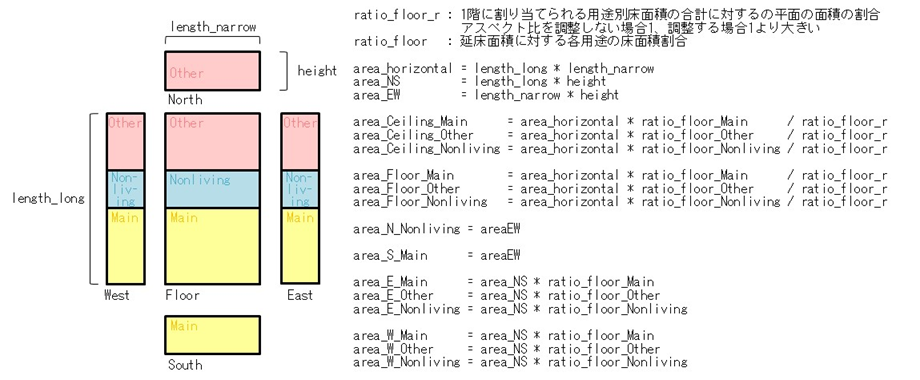

#### Function

In [19]:
# 共同住宅の面積算出
def get_area_condominium( area_floor_total, area_floor, area_floor_r, height, length_long, length_narrow, area_windows) :
    
    # 延床面積に対する用途別床面積の割合
    ratio_floor = { x : area_floor[x] / area_floor_total for x in area_floor.keys()}
 
    # アスペクト比を上限値により調整している場合、調整前の床面積に対する調整後の床面積の割合
    ratio_floor_r = sum( area_floor_r[x] for x in area_floor_r ) / sum( area_floor[x] for x in area_floor )
    
    area_horizontal = length_long * length_narrow
    area_NS = length_long * height
    area_EW = length_narrow * height

    # 窓面積の調整 南、北、西、東、天井の順に割付
    area_windows = adjust_window_area( area_windows, 
                                      [{'Direction':'S','AreaMax':area_EW},
                                       {'Direction':'N','AreaMax':area_EW},
                                       {'Direction':'W','AreaMax':area_NS},
                                       {'Direction':'E','AreaMax':area_NS},
                                       {'Direction':'Top','AreaMax':length_long * length_narrow / ratio_floor_r }] )
    area={}
    
    # 窓面積
    # 北窓はその他の居室、南窓は主たる居室、東窓・西窓は各用途に床面積案分で割り付け
    area['Windows']={
        'N' : {
            'main' : 0,
            'other' : area_windows['N'],
            'nonliving' : 0
        },
        'S' : {
            'main' : area_windows['S'],
            'other' : 0,
            'nonliving' : 0
        },
        'E' : {
            'main' :      area_windows['E'] * ratio_floor['main'],
            'other' :     area_windows['E'] * ratio_floor['other'],
            'nonliving' : area_windows['E'] * ratio_floor['nonliving']
        },
        'W' : {
            'main' :      area_windows['W'] * ratio_floor['main'],
            'other' :     area_windows['W'] * ratio_floor['other'],
            'nonliving' : area_windows['W'] * ratio_floor['nonliving']
        },
        'Top' : {
            'main' :      area_windows['Top'] * ratio_floor['main'],
            'other' :     area_windows['Top'] * ratio_floor['other'],
            'nonliving' : area_windows['Top'] * ratio_floor['nonliving']
        }
    }

    # 壁面積
    # 北壁はその他の居室、南壁は主たる居室、天井・床・東壁・西壁は各用途に床面積案分で割り付け
    area['Walls']={
        'Ceiling' : {
            'main' :      ( area_horizontal - area_windows['Top'] ) * ratio_floor['main']      / ratio_floor_r,
            'other' :     ( area_horizontal - area_windows['Top'] ) * ratio_floor['other']     / ratio_floor_r,
            'nonliving' : ( area_horizontal - area_windows['Top'] ) * ratio_floor['nonliving'] / ratio_floor_r
        },
        'Floor' : {
            'main' :      area_horizontal * ratio_floor['main']      / ratio_floor_r,
            'other' :     area_horizontal * ratio_floor['other']     / ratio_floor_r,
            'nonliving' : area_horizontal * ratio_floor['nonliving'] / ratio_floor_r
        },
        'WallN': {
            'main' : 0,
            'other' : area_EW - area_windows['N'],
            'nonliving' : 0
        },
        'WallS': {
            'main' : area_EW - area_windows['S'],
            'other' : 0,
            'nonliving' : 0
        },
        'WallE': {
            'main' :     ( area_NS - area_windows['E'] ) * ratio_floor['main'],
            'other' :    ( area_NS - area_windows['E'] ) * ratio_floor['other'],
            'nonliving' :( area_NS - area_windows['E'] ) * ratio_floor['nonliving']
        },
        'WallW': {
            'main' :     ( area_NS - area_windows['W'] ) * ratio_floor['main'],
            'other' :    ( area_NS - area_windows['W'] ) * ratio_floor['other'],
            'nonliving' :( area_NS - area_windows['W'] ) * ratio_floor['nonliving']
        }
    }
    
    # 内壁面積
    area['InnerWalls']={
        'main to other' :      area_EW,
        'main to lonliving' :  area_EW,
        'other to nonliving' : area_EW
    }
        
    return area

### 9) 部位の面積を取得する関数

#### Outline

基準値計算用の住宅について、用途別床面積、幾何形状、開口部面積、各部位の面積を取得する関数を統合する。  
各部位の面積より外壁・開口部・内壁のリストを作成する。

#### Function

In [20]:
def get_area(d):
    
    # 用途別床面積の取得
    area_floor=get_area_floor( d )

    # 幾何形状の取得
    n, height, floor_height, area_total_skin, length_narrow, length_long, area_floor_r = get_geometry( d, area_floor )
    
    # 開口部面積, ㎡
    area_windows = get_area_windows( d['Common']['HouseType'], area_total_skin )
    
    # 部位面積, ㎡
    if d['Common']['HouseType']== 'detached' :
        area = get_area_detached(d['Common']['TotalFloorArea'], \
                                 area_floor, area_floor_r, n, height, floor_height, length_long, length_narrow, area_windows)
    elif d['Common']['HouseType']== 'condominium' :
        area = get_area_condominium(d['Common']['TotalFloorArea'], \
                                    area_floor, area_floor_r, height, length_long, length_narrow, area_windows)
    
    # 外壁・開口部・内壁のリスト作成
    d = get_list( area )
   
    return d['Walls'], d['Windows'], d['InnerWalls']

In [21]:
get_area({
    'Common': {
        'Region': 6,
        'MainOccupantRoomFloorArea': 60.0,
        'OtherOccupantRoomFloorArea': 30.0,
        'TotalFloorArea': 120.0,
        'TotalOuterSkinArea': 360.0,
        'HouseType': 'detached' # 'detached','condominium'
    }
})

([{'name': 'Ceiling_main',
   'area': 15.000000000000002,
   'space': 'main',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood'},
  {'name': 'Ceiling_other',
   'area': 30.000000000000004,
   'space': 'other',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood'},
  {'name': 'Ceiling_nonliving',
   'area': 15.0,
   'space': 'nonliving',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood'},
  {'name': 'Floor_main',
   'area': 45.00000000000001,
   'space': 'main',
   'type': 'Floor',
   'direction': 'Bottom',
   'structure': 'Wood'},
  {'name': 'Floor_nonliving',
   'area': 15.0,
   'space': 'nonliving',
   'type': 'Floor',
   'direction': 'Bottom',
   'structure': 'Wood'},
  {'name': 'WallN_nonliving',
   'area': 75.64400000000002,
   'space': 'nonliving',
   'type': 'Wall',
   'direction': 'N',
   'structure': 'Wood'},
  {'name': 'WallS_main',
   'area': 35.85191428571429,
   'space': 'main',
   'type': 'Wall',
   'direction': 'S',
   '

## 4. 部位の性能の設定

### 4.1 各種設定値の取得

### 1) 外皮性能に関する基準値

エネルギーの使用の合理化に関する建築主等及び特定建築物の所有者の判断の基準の一部を改正する告示（平成28年4月1日施行）

戸建住宅

|  | 1地域 | 2地域 | 3地域 | 4地域 | 5地域 | 6地域 | 7地域 | 8地域 |
|---|---|---|---|---|---|---|---|---|
| 平均熱貫流率[W/(㎡・K)] | 0.46 | 0.46 | 0.56 | 0.75 | 0.87 | 0.87 | 0.87 | 2.14 |
| 暖房期の平均日射熱取得率[-] | 2.5 | 2.3 | 2.7 | 3.7 | 4.5 | 4.3 | 4.6 | - |
| 冷房期の平均日射熱取得率[-] | 1.9 | 1.9 | 2.0 | 2.7 | 3.0 | 2.8 | 2.7 | 3.2 | 

共同住宅

|  | 1地域 | 2地域 | 3地域 | 4地域 | 5地域 | 6地域 | 7地域 | 8地域 |
|---|---|---|---|---|---|---|---|---|
| 平均熱貫流率[W/(㎡・K)] | 0.41 | 0.41 | 0.44 | 0.69 | 0.75 | 0.75 | 0.75 | 1.67 |
| 暖房期の平均日射熱取得率[-] | 1.5 | 1.3 | 1.5 | 1.8 | 2.1 | 2.0 | 2.1 | - |
| 冷房期の平均日射熱取得率[-] | 1.1 | 1.1 | 1.1 | 1.4 | 1.5 | 1.4 | 1.3 | 2.4 | 

#### Function

In [22]:
def get_std_UA(house_type, region):
    return {
        'detached'    : {1: 0.46, 2: 0.46, 3: 0.56, 4: 0.75, 5: 0.87, 6: 0.87, 7: 0.87, 8: 2.14 },
        'condominium' : {1: 0.41, 2: 0.41, 3: 0.44, 4: 0.69, 5: 0.75, 6: 0.75, 7: 0.75, 8: 1.67 },
    }[house_type][region]

def get_std_etaAH(house_type, region):
    return {
        'detached'    : {1: 2.5,  2: 2.3,  3: 2.7,  4: 3.7,  5: 4.5,  6: 4.3,  7: 4.6,  8: "-"  },
        'condominium' : {1: 1.5,  2: 1.3,  3: 1.5,  4: 1.8,  5: 2.1,  6: 2.0,  7: 2.1,  8: "-"  },
    }[house_type][region]

def get_std_etaAC(house_type, region):
    return {
        'detached'    : {1: 1.9,  2: 1.9,  3: 2.0,  4: 2.7,  5: 3.0,  6: 2.8,  7: 2.7,  8: 3.2  },
        'condominium' : {1: 1.1,  2: 1.1,  3: 1.1,  4: 1.4,  5: 1.5,  6: 1.4,  7: 1.3,  8: 2.4  },
    }[house_type][region]

### 2) 部位別の熱貫流率の基準値、想定値

基準値計算用の部位別の熱貫流率の基準値または想定値は、現行の省エネルギー基準等を参考に設定する。

　屋根または天井・壁・床・開口部：  
 　　住宅に係るエネルギーの使用の合理化に関する設計、施工及び維持保全の指針の一部を改正する告示（平成28年4月1日施行）  
　壁・床（8地域）：RC150mm（無断熱）を想定  
　窓（8地域）：単板ガラスの熱貫流率を想定

部位別の熱貫流率の基準値、想定値, W/(㎡・K)

| 部位 | 1地域 | 2地域 | 3地域 | 4地域 | 5地域 | 6地域 | 7地域 | 8地域 |
|---|---|---|---|---|---|---|---|
| 屋根・天井 | 0.17 | 0.17 | 0.24 | 0.24 | 0.24 | 0.24 | 0.24 | 0.24 |
| 壁 | 0.35 | 0.35 | 0.53 | 0.53 | 0.53 | 0.53 | 0.53 | 4.10 |
| 床 | 0.34 | 0.34 | 0.34 | 0.48 | 0.48 | 0.48 | 0.48 | 3.52 |
| 開口部 | 2.33 | 2.33 | 3.49 | 4.65 | 4.65 | 4.65 | 4.65 | 6.51 |

#### Function

In [23]:
def get_std_U(region, part_type) :

    return {
        'Ceiling' : {1: 0.17, 2: 0.17, 3: 0.24, 4: 0.24, 5: 0.24, 6: 0.24, 7: 0.24, 8: 0.24 },
        'Wall'    : {1: 0.35, 2: 0.35, 3: 0.53, 4: 0.53, 5: 0.53, 6: 0.53, 7: 0.53, 8: 4.10 },
        'Floor'   : {1: 0.34, 2: 0.34, 3: 0.34, 4: 0.48, 5: 0.48, 6: 0.48, 7: 0.48, 8: 3.52 },
        'Window'  : {1: 2.33, 2: 2.33, 3: 3.49, 4: 4.65, 5: 4.65, 6: 4.65, 7: 4.65, 8: 6.51 }
    }[part_type][region]

#### Example

In [24]:
get_std_U(6, 'Ceiling')

0.24

In [25]:
get_std_U(6, 'Wall')

0.53

In [26]:
get_std_U(6, 'Floor')

0.48

In [27]:
get_std_U(6, 'Window')

4.65

### 3) 部位別の熱貫流率の上下限値

#### Outline

下限値は十分に小さい値、上限値は合板12mmを想定。

|  | 下限値[W/(㎡・K)] | 上限値[W/(㎡・K)] |
|---|---|---|
| 屋根・天井 | 0.001 | 1/(0.09+0.012/0.16+0.04) = 4.80 |
| 壁 | 0.001 | 1/(0.11+0.012/0.16+0.04) = 4.40 |
| 床 | 0.001 | 1/(0.15+0.012/0.16+0.15) = 2.60 |
| 開口部 | 0.001 | 6.51 |

#### Function

In [28]:
# 熱貫流率の下限値 W/(㎡・K)
def get_wall_min_U():
    
    wall_min_U={
        'Ceiling'    : 0.001,
        'Wall'       : 0.001,
        'Floor'      : 0.001,
        'Window'     : 0.001
    }
    
    return wall_min_U

In [29]:
# 部位別の熱貫流率の上限値, W/(㎡・K)
def get_wall_max_U() :
    
    wall_max_U={
        'Ceiling' : 1/(0.09+0.012/0.16+0.04),
        'Wall'    : 1/(0.11+0.012/0.16+0.04),
        'Floor'   : 1/(0.15+0.012/0.16+0.15),
        'Window'  : 6.51
    }
    
    return wall_max_U

### 4) 外皮の部位及び土間床等の周辺部の温度差係数

平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）  
2.エネルギー消費性能の算定方法  
2.2 算定方法  
第三章 暖冷房負荷と外皮性能  
第二節 外皮性能   
付録 B 温度差係数

| 隣接空間の種類 | 1～3地域 | 4～8地域 |
|---|---|---|
| 外気 | 1.0 | 1.0 |
| 外気に通じる空間 | 1.0 | 1.0 |
| 外気に通じていない空間 | 0.7 | 0.7 |
| 外気に通じる床裏 | 0.7 | 0.7 |
| 住戸及び住戸と同様の熱的環境の空間 | 0.05 | 0.15 |
| 外気に通じていない床裏 | 0.05 | 0.15 |

部位の種類と隣接空間の種類

| 部位の種類 | 隣接空間の種類 |
|---|---|
| 天井 | 外気 |
| 床 | 外気に通じる床裏 |
| 壁 | 外気 |
| 窓 | 外気 |

#### Function

In [30]:
def get_H_by_space_type(region, space_type):

    return {
        # 外気又は外気に通じる空間(小屋裏・天井裏・共用部・屋内駐車場・メーターボックス・エレベーターシャフト等)
        'outside'    : {1: 1.00, 2: 1.00, 3: 1.00, 4: 1.00, 5: 1.00, 6: 1.00, 7: 1.00, 8: 1.00 }, 
        # 外気に通じていない空間(昇降機室、共用機械室、倉庫等)又は外気に通じる床裏
        'underfloor' : {1: 0.70, 2: 0.70, 3: 0.70, 4: 0.70, 5: 0.70, 6: 0.70, 7: 0.70, 8: 0.70 }, 
        # 住戸、住戸と同様の熱的環境の空問(空調された共用部等)又は外気に通じていない床裏(ピット等）
        'next_room'  : {1: 0.05, 2: 0.05, 3: 0.05, 4: 0.15, 5: 0.15, 6: 0.15, 7: 0.15, 8: 0.15 }  
    }[space_type][region]

def get_H_by_parts(region, parts_type):
    
    return {
        'Ceiling' : get_H_by_space_type(region, 'outside'),
        'Floor'   : get_H_by_space_type(region, 'underfloor'),
        'Wall'    : get_H_by_space_type(region, 'outside'),
        'Window'  : get_H_by_space_type(region, 'outside'),
    }[parts_type]

### 6) 日射取得率補正係数

#### Function

In [31]:
def get_f(season, region, direction):

    return {
        'heating' :{
            'Top'    : {1: 1.000, 2: 1.000, 3: 1.000, 4: 1.000, 5: 1.000, 6: 1.000, 7: 1.000, 8: '-' },
            'N'      : {1: 0.862, 2: 0.860, 3: 0.862, 4: 0.861, 5: 0.867, 6: 0.870, 7: 0.873, 8: '-' },
            'NE'     : {1: 0.848, 2: 0.851, 3: 0.850, 4: 0.846, 5: 0.838, 6: 0.839, 7: 0.833, 8: '-' },
            'E'      : {1: 0.871, 2: 0.873, 3: 0.869, 4: 0.874, 5: 0.874, 6: 0.874, 7: 0.868, 8: '-' },
            'SE'     : {1: 0.892, 2: 0.888, 3: 0.885, 4: 0.883, 5: 0.894, 6: 0.896, 7: 0.892, 8: '-' },
            'S'      : {1: 0.892, 2: 0.880, 3: 0.884, 4: 0.874, 5: 0.894, 6: 0.889, 7: 0.896, 8: '-' },
            'SW'     : {1: 0.888, 2: 0.885, 3: 0.885, 4: 0.882, 5: 0.891, 6: 0.885, 7: 0.894, 8: '-' },
            'W'      : {1: 0.869, 2: 0.874, 3: 0.871, 4: 0.872, 5: 0.871, 6: 0.874, 7: 0.870, 8: '-' },
            'NW'     : {1: 0.850, 2: 0.850, 3: 0.850, 4: 0.845, 5: 0.840, 6: 0.844, 7: 0.834, 8: '-' },
            'Bottom' : {1: 0.000, 2: 0.000, 3: 0.000, 4: 0.000, 5: 0.000, 6: 0.000, 7: 0.000, 8: '-' }
        },
        'cooling' :{
            'Top'    : {1: 1.000, 2: 1.000, 3: 1.000, 4: 1.000, 5: 1.000, 6: 1.000, 7: 1.000, 8: 1.000 },
            'N'      : {1: 0.853, 2: 0.857, 3: 0.853, 4: 0.852, 5: 0.860, 6: 0.847, 7: 0.838, 8: 0.848 },
            'NE'     : {1: 0.865, 2: 0.864, 3: 0.862, 4: 0.861, 5: 0.863, 6: 0.862, 7: 0.861, 8: 0.857 },
            'E'      : {1: 0.882, 2: 0.877, 3: 0.870, 4: 0.881, 5: 0.874, 6: 0.880, 7: 0.881, 8: 0.877 },
            'SE'     : {1: 0.864, 2: 0.858, 3: 0.853, 4: 0.853, 5: 0.854, 6: 0.852, 7: 0.849, 8: 0.860 },
            'S'      : {1: 0.807, 2: 0.812, 3: 0.799, 4: 0.784, 5: 0.807, 6: 0.795, 7: 0.788, 8: 0.824 },
            'SW'     : {1: 0.860, 2: 0.861, 3: 0.859, 4: 0.850, 5: 0.858, 6: 0.852, 7: 0.847, 8: 0.858 },
            'W'      : {1: 0.880, 2: 0.878, 3: 0.883, 4: 0.876, 5: 0.875, 6: 0.880, 7: 0.880, 8: 0.876 },
            'NW'     : {1: 0.866, 2: 0.864, 3: 0.865, 4: 0.861, 5: 0.862, 6: 0.864, 7: 0.862, 8: 0.859 },
            'Bottom' : {1: 0.000, 2: 0.000, 3: 0.000, 4: 0.000, 5: 0.000, 6: 0.000, 7: 0.000, 8: 0.000 }        
        }
    }[season][direction][region]

### 4.2 部位の性能値の算出

### 1) 熱貫流率の調整係数の上下限値の算出

#### Outline

屋根または天井、外壁、開口部の熱貫流率を調整するための係数$f_{U,s}$の最小値、最大値は、以下の方法で決定する。  
  
　最小値：以下の値のうち、大きい方の値を採用する  
　　-床の熱貫流率が最大値を取る場合に、UA値の基準値より算出される、屋根または天井、外壁、開口部の熱貫流率の調整係数  
　　-屋根または天井、外壁、開口部の熱貫流率の基準値に対する最小値の割合　各部位の値についての最大値    
  
　最大値：以下の値のうち、小さい方の値を採用する  
　　-床の熱貫流率が最小値を取る場合に、UA値の基準値より算出される、屋根または天井、外壁、開口部の熱貫流率の調整係数  
　　-屋根または天井、外壁、開口部の熱貫流率の基準値に対する最大値の割合　各部位の値についての最小値    

$$
\displaystyle
f_{U,s,min}= \max \left(\frac{ (AU_{A}) - (AUH)_n \times \frac{ U_{f,max}}{U_{f,int}} }{ (AUH)_s },\max \left(\frac{U_{i,min}}{U_{i,int}} \right) \right)
$$

$$
\displaystyle
f_{U,s,max}= \min \left(\frac{ (AU_{A}) - (AUH)_n \times \frac{ U_{f,min}}{U_{f,int}} }{ (AUH)_s },\min \left(\frac{U_{i,max}}{U_{i,int}} \right) \right)
$$

床の熱貫流率を調整するための係数$f_{U,n}$の最小値、最大値は、以下の方法で決定する。  
  
　最小値：以下の値のうち、大きい方の値を採用する  
　　-屋根または天井、外壁、開口部の熱貫流率が最大値を取る場合に、UA値の基準値より算出される、床の熱貫流率の調整係数  
　　-床の熱貫流率の基準値に対する最小値の割合    
  
　最大値：以下の値のうち、小さい方の値を採用する  
　　-屋根または天井、外壁、開口部の熱貫流率が最小値を取る場合に、UA値の基準値より算出される、床の熱貫流率の調整係数  
　　-床の熱貫流率の基準値に対する最大値の割合

$$
\displaystyle
f_{U,n,min}= \max \left(\frac{ (AU_{A}) - (AUH)_s \times \min(\frac{U_{i,max}}{U_{i,int}}) }{ (AUH)_n },\frac{U_{f,min}}{U_{f,int}} \right)
$$

$$
\displaystyle
f_{U,n,max}= \min \left(\frac{ (AU_{A}) - (AUH)_s \times \max(\frac{U_{i,min}}{U_{i,int}}) }{ (AUH)_n },\frac{U_{f,max}}{U_{f,int}} \right)
$$

$(AU_{A})$: 総外皮面積と外皮平均熱貫流率の基準値の積（後述）, W/K   
$(AUH)_s$: 日射の当たる部位（屋根または天井、外壁、開口部）の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K  
$(AUH)_n$: 日射の当たらない部位（床）の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K 

$f_{U,s,min}$: 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率を補正するための係数が取り得る最小値, -  
$f_{U,n,min}$: 日射の当たらない部位（床）の熱貫流率を補正するための係数が取り得る最小値, -  
$f_{U,s,max}$: 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率を補正するための係数が取り得る最大値, -  
$f_{U,n,max}$: 日射の当たらない部位（床）の熱貫流率を補正するための係数が取り得る最大値, -  
$U_{i,int}$: 日射の当たる部位（屋根または天井、外壁、開口部）$i$の熱貫流率の基準値, W/(m<sup>2</sup>・K)  
$U_{i,min}$: 日射の当たる部位（屋根または天井、外壁、開口部）$i$の熱貫流率の最小値, W/(m<sup>2</sup>・K)  
$U_{i,max}$: 日射の当たる部位（屋根または天井、外壁、開口部）$i$の熱貫流率の最大値, W/(m<sup>2</sup>・K)  
$U_{f,int}$: 日射の当たらない部位（床）の熱貫流率の基準値, W/(m<sup>2</sup>・K)  
$U_{f,min}$: 日射の当たらない部位（床）の熱貫流率の最小値, W/(m<sup>2</sup>・K)  
$U_{f,max}$: 日射の当たらない部位（床）の熱貫流率の最大値, W/(m<sup>2</sup>・K)  

#### Function

In [32]:
# 熱貫流率の調整係数の上下限値
def get_fU_range(region, UA, max_U, min_U, sum_UAHs, sum_UAHn ):
    
    # 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率補正係数の最小値
    fUs_max_temp1 = ( UA - sum_UAHn * min_U['Floor'] / get_std_U(region, 'Floor') ) / sum_UAHs
    fUs_max_temp2 = min( max_U[x] / get_std_U(region, x) for x in ['Ceiling','Wall','Window'] )
    fUs_max = min( fUs_max_temp1 , fUs_max_temp2 )
    
    # 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率補正係数の最大値
    fUs_min_temp1 = ( UA - sum_UAHn * max_U['Floor'] / get_std_U(region, 'Floor') ) / sum_UAHs
    fUs_min_temp2 = max( min_U[x] / get_std_U(region, x) for x in ['Ceiling','Wall','Window'] )
    fUs_min = max( fUs_min_temp1, fUs_min_temp2 )
    
    # 日射の当たらない部位（床）の熱貫流率補正係数の最小値
    fUs_max_temp1 = ( UA - sum_UAHs * max( min_U[x] / get_std_U(region, x) for x in ['Ceiling','Wall','Window'] ) ) / sum_UAHn
    fUs_max_temp2 = max_U['Floor'] / get_std_U(region, 'Floor')
    fUn_max = min( fUs_max_temp1, fUs_max_temp2 )
    
    # 日射の当たらない部位（床）の熱貫流率補正係数の最大値
    fUn_min_temp1 = ( UA - sum_UAHs *  min( max_U[x] / get_std_U(region, x) for x in ['Ceiling','Wall','Window'] ) ) / sum_UAHn
    fUn_min_temp2 = min_U['Floor'] / get_std_U(region, 'Floor')
    fUn_min = max( fUn_min_temp1, fUn_min_temp2 )
    
    return { 'fUs' : { 'max' : fUs_max, 'min' :fUs_min }, 'fUn' : { 'max' : fUn_max, 'min' :fUn_min } }

### 2) 熱貫流率調整係数と開口部日射熱取得率の算出

#### Outline

UA値、ηA値の基準値を満たすように、基準値計算用の住宅のU値（仕様規定の部位別U値に比例）と開口部の日射熱取得率η値を決定する。 

$$
\displaystyle
f_{U}= \frac{ (AU_{A}) }{ (AUH) }
$$

$$
\displaystyle
η_{H}= \frac{ \frac{ (Aη_{A})_H }{100} - 0.034 \times f_{U} \times (AUν)_H }{ (Afν)_H }
$$
$$
\displaystyle
η_{C}= \frac{ \frac{ (Aη_{A})_C }{100} - 0.034 \times f_{U} \times (AUν)_C }{ (Afν)_C }
$$

ただし、非現実的な設定は許容せず、開口部のη値は0以上0.88以下、各部位のU値は上下限値の間とする。  
そのために、調整前の冷房期と暖房期の開口部のη値が0未満または0.88超となる場合について、場合分けを行い調整を実施する。

$f_{U}$: 熱貫流率の調整係数, -  
$η_{H}$: 暖房期の開口部の日射熱取得率, -  
$η_{C}$: 冷房期の開口部の日射熱取得率, -  

$(AU_{A})$: 総外皮面積と外皮平均熱貫流率の基準値の積（後述）, W/K   
$(AUH)$: 部位の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K 

$(Aη_{A})_H$: 総外皮面積と暖房期の外皮平均日射熱取得率の基準値の積（後述）, ㎡  
$(Aη_{A})_C$: 総外皮面積と冷房期の外皮平均日射熱取得率の基準値の積（後述）, ㎡  
$(AUν)_H$: 開口部以外の外皮の部位の面積と熱貫流率の基準値と方位係数の積の合計（後述）, W/K   
$(AUν)_C$: 開口部以外の外皮の部位の面積と熱貫流率の基準値と方位係数の積の合計（後述）, W/K   
$(Afν)_H$: 開口部の部位の面積と暖房期の日射取得率補正係数と方位係数の積の合計（後述）, W/K   
$(Afν)_C$: 開口部の部位の面積と冷房期の日射取得率補正係数と方位係数の積の合計（後述）, W/K   

#### Detail

場合分けは、以下のとおりとする。  

　1 冷房期の開口部以外からの日射熱取得が多い場合（調整前$η_C<0$）  
　　1-1 暖房期の開口部以外からの日射熱取得が多い場合（調整前$η_H<0$）  
　　　　より厳しい期間に合わせて日射が当たる部位の熱貫流率を調整  
　　1-2 暖房期の日射熱取得が少ない場合（調整前$η_H>0.88$）  
　　　　UA値をもとに部位の熱貫流率を調整  
　　1-3 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合（$0$≦調整前$η_H$≦$0.88$）  
　　　　冷房期を優先して日射が当たる部位の熱貫流率を調整  
        
　2 冷房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合（$0$≦調整前$η_C$≦$0.88$）  
　　2-1 暖房期の開口部以外からの日射熱取得が多い場合（調整前$η_H<0$）  
　　　　暖房期を優先して日射が当たる部位の熱貫流率を調整  
　　2-2 暖房期の日射熱取得が少ない場合（調整前$η_H>0.88$）  
　　　　暖房期を優先して日射が当たる部位の熱貫流率を調整  
　　2-3 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合（$0$≦調整前$η_H$≦$0.88$）  
 　　　　UA値をもとに部位の熱貫流率を調整 
     
　3 冷房期の日射熱取得が少ない場合（調整前$η_C>0.88$）  
　　3-1 暖房期の開口部以外からの日射熱取得が多い場合（調整前$η_H<0$）  
　　　　UA値をもとに部位の熱貫流率を調整  
　　3-2 暖房期の日射熱取得が少ない場合（調整前$η_H>0.88$）  
　　　　より厳しい期間に合わせて日射が当たる部位の熱貫流率を調整  
　　3-3 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合（$0$≦調整前$η_H$≦$0.88$）  
　　　　冷房期を優先して日射が当たる部位の熱貫流率を調整  

|  | 調整前$η_H<0$ | $0$≦調整前$η_H$≦$0.88$ | $0.88<$調整前$η_H$ |
|---|---|---|---|
| 調整前$η_C<0$ | (1-1)より厳しい期間に合わせて$f_U$を決定 | (2-1)冷房期を優先して$f_U$を決定 | (3-1)$U_A$値をもとに$f_U$を決定 | 
|  | $$f_{U} = \frac{ \frac{( Aη_A) }{100} }{ 0.034 \times (AUν) }$$ | $$f_{U} = \frac{ \frac{( Aη_A) }{100} }{ 0.034 \times (AUν) }$$ | $$f_{U} = \frac{(AU_A) }{ (AUH) }$$ |
| $0$≦調整前$η_C$≦$0.88$ | (1-2)暖房期を優先して$f_U$を決定 | (2-2)$U_A$値をもとに$f_U$を決定 | (3-2)暖房期を優先して$f_U$を決定 |
|  | $$f_{U} = \frac{ \frac{( Aη_A) }{100} }{ 0.034 \times (AUν) }$$ | $$f_{U} = \frac{(AU_A) }{ (AUH) }$$ | $$f_{U} = \frac{ \frac{( Aη_A) }{100} - 0.88 \times (Afν) }{ 0.034 \times (AUν)}$$ |
| $0.88<$調整前$η_C$ | (1-3)$U_A$値をもとに$f_U$を決定 | (2-3)冷房期を優先して$f_U$を決定 | (3-3)より厳しい期間に合わせて$f_U$を決定 |
|  | $$f_{U} = \frac{(AU_A) }{ (AUH) }$$ | $$f_{U} = \frac{ \frac{( Aη_A) }{100} - 0.88 \times (Afν) }{ 0.034 \times (AUν)}$$ | $$f_{U} = \frac{ \frac{( Aη_A) }{100} - 0.88 \times (Afν) }{ 0.034 \times (AUν)}$$ |

熱貫流率の調整係数は、日射の当たる部位（屋根または天井、外壁、開口部）と、日射の当たらない部位（床）のそれぞれについて算出する。

　$f_{U,s}$ :日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率の調整係数  
　$f_{U,n}$ :日射の当たらない部位（床）の熱貫流率の調整係数
 
 熱貫流率の調整係数は、下限値以上、上限値以下となるよう決定する。

$$
f_{U,s} = \left \{
\begin{array}{ll}
\displaystyle
\max \left(f_{U,s,min},\frac{ \frac{( Aη_A) }{100} }{ 0.034 \times (AUν) } \right) & \left( \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } < 0.00 \right) \\
\displaystyle
\min \left(f_{U,s,max},\max \left(f_{U,s,min}, \frac{(AU_A) }{ (AUH) } \right)\right) & \left( 0.00 ≦ \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } ≦ 0.88 \right) \\
\displaystyle
\min \left(f_{U,s,max},\frac{ \frac{( Aη_A) }{100} - 0.88 \times (Afν) }{ 0.034 \times (AUν)} \right) & \left( \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } > 0.88 \right)
\end{array}
\right.
$$

$f_{U,s}$: 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率を補正するための係数, -  
$f_{U,s,min}$: 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率を補正するための係数が取り得る最小値, -  
$f_{U,s,max}$: 日射の当たる部位（屋根または天井、外壁、開口部）の熱貫流率を補正するための係数が取り得る最大値, -  

$(AU_{A})$: 総外皮面積と外皮平均熱貫流率の基準値の積（後述）, W/K   
$(Aη_{A})$: 総外皮面積と外皮平均日射熱取得率の基準値の積（後述）, ㎡  
$(AUH)$: 部位の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K  
$(AUν)$: 開口部以外の外皮の部位の面積と熱貫流率の基準値と方位係数の積の合計（後述）, W/K   
$(Afν)$: 開口部の部位の面積と日射取得率補正係数と方位係数の積の合計（後述）, W/K     

$$
f_{U,n} = \min \left( f_{U,n,max},\max \left( f_{U,n,min},\frac{ (AU_A) - f_{U,s} \times (AUH)s }{ (AUH)_n } \right) \right)
$$

$f_{U,n}$: 日射の当たらない部位（床）の熱貫流率を補正するための係数, -  
$f_{U,n,min}$: 床の熱貫流率を補正するための係数が取り得る最小値, -  
$f_{U,n,max}$: 床の熱貫流率を補正するための係数が取り得る最大値, -  

$(AUH)_s$: 日射の当たる部位（屋根または天井、外壁、開口部）の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K  
$(AUH)_n$: 日射の当たらない部位（床）の面積と熱貫流率の基準値と温度差係数の積の合計（後述）, W/K 

開口部の日射熱取得率は、0以上、0.88以下となるよう決定する。  
開口部以外からの日射熱取得が多い場合は、日射の当たる部位の熱貫流率の調整係数を、開口部の日射熱取得率が0となるよう、熱貫流率の調整係数の下限値以上となる範囲で調整する。  
日射熱取得が少ない場合は、日射の当たる部位の熱貫流率の調整係数を、開口部の日射熱取得率が0.88となるよう、熱貫流率の調整係数の上限値以下となる範囲で調整する。

$$
η = \left \{
\begin{array}{ll}
0.00 & \left( \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } < 0.00 \right) \\
\displaystyle
\min \left(0.88,\max \left(0.00, \frac{ \frac{(Aη_A)}{100} - 0.034 \times f_{U,s} \times (AUν) }{ (Afν) } \right)\right) & \left( 0.00 ≦ \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } ≦ 0.88 \right) \\
0.88 & \left( \frac{ \frac{(Aη_A)}{100} - 0.034 \times(AUν) }{ (Afν) } > 0.88 \right)
\end{array}
\right.
$$

$η$: 開口部の日射熱取得率, -  

#### Function

In [33]:
def calc_fU_and_eta( sum_AUnu, sum_Afnu, Aeta, UA, sum_UAH, sum_UAHs, sum_UAHn, fU_range ):
    
    # 場合分けのためのη暫定値
    eta_temp={ x : ( Aeta[ x ] / 100 - 0.034 * sum_AUnu[ x ] ) / sum_Afnu[ x ] for x in [ 'Heating', 'Cooling' ] }
    
    # 調整係数を事前に算出
    fUs_for_eta_000 = { x : Aeta[ x ]/100 / 0.034 / sum_AUnu[ x ] for x in [ 'Heating', 'Cooling' ] }
    fUs_for_eta_088 = { x : ( Aeta[ x ]/ 100 - 0.88 * sum_Afnu[ x ] ) / 0.034 / sum_AUnu[ x ] for x in [ 'Heating', 'Cooling' ] }
    fUs_for_UA = UA / sum_UAH

    # 1 冷房期の開口部以外からの日射熱取得が多い場合
    if eta_temp['Cooling'] < 0 :
        
        # 1-1 暖房期の開口部以外からの日射熱取得が多い場合
        # より厳しい期間に合わせて日射が当たる部位の熱貫流率を調整
        if eta_temp['Heating'] < 0 :
            fUs = min( fUs_for_eta_000['Heating'], fUs_for_eta_000['Cooling'] )

        # 1-3 暖房期の日射熱取得が少ない場合
        # UA値をもとに部位の熱貫流率を調整
        elif eta_temp['Heating'] > 0.88 :
            fUs = min( fUs_max, fUs_for_UA )
            
        # 1-2 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合
        # 冷房期を優先して日射が当たる部位の熱貫流率を調整
        else :
            fUs = fUs_for_eta_000['Cooling']

    # 3 冷房期の日射熱取得が少ない場合
    elif eta_temp['Cooling'] > 0.88 :
        
        # 3-1 暖房期の開口部以外からの日射熱取得が多い場合
        # UA値をもとに部位の熱貫流率を調整
        if eta_temp['Heating'] < 0 :
            fUs = min( fUs_max, fUs_for_UA )
       
        # 3-3 暖房期の日射熱取得が少ない場合
        # より厳しい期間に合わせて日射が当たる部位の熱貫流率を調整
        elif eta_temp['Heating'] > 0.88 :
            fUs = max( fUs_for_eta_088['Cooling'], fUs_for_eta_088['Cooling'] )   
           
        # 3-2 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合
        # 冷房期を優先して日射が当たる部位の熱貫流率を調整
        else :
            fUs = fUs_for_eta_088['Cooling']
   
    # 2 冷房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合
    else :
        # 2-1 暖房期の開口部以外からの日射熱取得が多い場合
        # 暖房期を優先して日射が当たる部位の熱貫流率を調整
        if eta_temp['Heating'] < 0 :
            fUs = fUs_for_eta_000['Heating']
        
        # 2-3 暖房期の日射熱取得が少ない場合
        # 暖房期を優先して日射が当たる部位の熱貫流率を調整
        elif eta_temp['Heating'] > 0.88 :
            fUs = fUs_for_eta_088['Heating']
            
        # 2-2 暖房期の日射熱取得が開口部の日射熱取得率で調整可能な範囲の場合
        # UA値をもとに部位の熱貫流率を調整
        else :
            fUs = fUs_for_UA
    
    # 上下限値の適用
    fUs = max( fU_range['fUs']['min'], min( fU_range['fUs']['max'], fUs_for_UA ))
    
    # 床の熱貫流率の調整係数
    fUn = max( fU_range['fUn']['min'], min( fU_range['fUn']['max'], ( UA - fUs * sum_UAHs ) / sum_UAHn ))
    
    # 開口部の日射熱取得率の算出
    eta = { x : max( 0, min( 0.88, ( Aeta[x] / 100 - 0.034 * sum_AUnu[x] * fUs ) / sum_Afnu[x])) for x in [ 'Heating', 'Cooling' ]}
    
    return fUs, fUn, eta

### 3) 基準値計算用の住宅のUA値、ηA値の検算

#### Outline

$$
\displaystyle
U_{A,check}= \frac{ \sum_{}^{}(U_i \times A_i \times H_i) }{ A_{total} }
$$

$$
\displaystyle
η_{A,H,check}= \frac{ 0.034 \times \sum_{}^{}(U_{o,i} \times A_{o,i} \times ν_{H,o,i}) + η_H \times (Afν)_H}{ A_{total} } \times 100
$$
$$
\displaystyle
η_{A,C,check}= \frac{ 0.034 \times \sum_{}^{}(U_{o,i} \times A_{o,i} \times ν_{C,o,i}) + η_C \times (Afν)_C}{ A_{total} } \times 100
$$

$U_{A,check}$: 外皮平均熱貫流率の検算値, W/(m<sup>2</sup>・K)  
$η_{A,check}$: 外皮平均日射熱取得率の検算値, -  

$(Afν)_H$: 開口部の部位の面積と暖房期の日射取得率補正係数と方位係数の積の合計（後述）, W/K   
$(Afν)_C$: 開口部の部位の面積と冷房期の日射取得率補正係数と方位係数の積の合計（後述）, W/K   

$ν$: 部位の方位係数, -  
$H$: 温度差係数, -  
$A$: 部位の面積, m<sup>2</sup>  
$U$: 部位の熱貫流率, W/(m<sup>2</sup>・K)  

添字$H$: 暖房期  
添字$C$: 冷房期  
添字$i$: 外皮の第$i$番目の部位  
添字$o,i$: 開口部以外の外皮の第$i$番目の部位  
添字$w,i$: 開口部の第$i$番目の部位  

In [34]:
def check_UA_and_etaA( area_skin, d_Walls, d_Windows, H, part_U, eta, sum_Afnu,region):
    
    UA_check=sum( x['area'] * part_U[x['type']] * H[x['type']] for x in d_Walls+d_Windows ) / area_skin

    eta_check = {
        'Heating' : (0.034 * sum(x['area'] * part_U[x['type']] * nu.get_nu(region=region, season='heating', direction=x['direction']) for x in d_Walls) + eta['Heating'] * sum_Afnu['Heating']) / area_skin * 100,
        'Cooling' : (0.034 * sum(x['area'] * part_U[x['type']] * nu.get_nu(region=region, season='cooling', direction=x['direction']) for x in d_Walls) + eta['Cooling'] * sum_Afnu['Cooling']) / area_skin * 100,
    }
    
    return UA_check, eta_check

### 4) 基準値計算用の住宅のUA値、ηA値の調整

#### Outline

各種設定値を取得する。  
熱貫流率調整係数と開口部日射熱取得率の算出のための各種値を算出する。  
熱貫流率調整係数と開口部日射熱取得率を算出する。  
基準値計算用の住宅のUA値、ηA値の確認を行う。

熱貫流率調整係数と開口部日射熱取得率の算出のための各種値は以下のとおり。

$$
\displaystyle
(Aη_{A})_H= η_{A,H} \times A_{total} 
$$
$$
\displaystyle
(Aη_{A})_C= η_{A,C} \times A_{total} 
$$
$$
\displaystyle
(AU_{A})= U_{A,s} \times A_{total} 
$$

$U_{A,s}$: 外皮平均熱貫流率の基準値, W/(m<sup>2</sup>・K)  
$η_{A,H}$: 暖房期の外皮平均日射熱取得率の基準値, -  
$η_{A,C}$: 冷房期の外皮平均日射熱取得率の基準値, -  
$A_{total}$: 総外皮面積, m<sup>2</sup>  
添字$H$: 暖房期  
添字$C$: 冷房期  

$$
\displaystyle
(AUν)_H= \sum_{}^{}(A_{o,i} \times U_{S,o,i} \times ν_{H,o,i})
$$
$$
\displaystyle
(AUν)_C= \sum_{}^{}(A_{o,i} \times U_{S,o,i} \times ν_{C,o,i})
$$

$ν$: 部位の方位係数, -  
$A$: 部位の面積, m<sup>2</sup>  
$U_{o,s,i}$: 開口部以外の外皮の第$i$番目の部位の熱貫流率の基準値, W/(m<sup>2</sup>・K)  
添字$o,i$: 開口部以外の外皮の第$i$番目の部位  

$$
\displaystyle
(Afν)_H= \sum_{}^{}(A_{w,i} \times f_{s,w,i} \times ν_{H,w,i})
$$
$$
\displaystyle
(Afν)_C= \sum_{}^{}(A_{w,i} \times f_{s,w,i} \times ν_{C,w,i})
$$

$f$: 部位の日射取得率補正係数, -  
添字$w,i$: 開口部の第$i$番目の部位  

$$
\displaystyle
(AUH)= \sum_{}^{}(A_{i} \times U_{s,i} \times H_{i})
$$
$$
\displaystyle
(AUH)_s= \sum_{}^{}(A_{s,i} \times U_{s,s,i} \times H_{s,i})
$$
$$
\displaystyle
(AUH)_n= \sum_{}^{}(A_{n,i} \times U_{s,n,i} \times H_{n,i})
$$

$H$: 温度差係数, -  
$U_{s}$: 開口部以外の外皮の第$i$番目の部位の熱貫流率の基準値, W/(m<sup>2</sup>・K)  
添字$i$: 外皮の第$i$番目の部位  
添字$s,i$: 日射の当たる部位（屋根または天井、外壁、開口部）の第$i$番目の部位  
添字$n,i$: 日射の当たらない部位（床）の第$i$番目の部位  

In [ ]:
class Parts:
    
    def __init__(self, area, part_type, direction):
        self.__area = area
        self.__part_type = part_type
        self.__direction = direction
    
    @property
    def area(self):
        return self.__area

    @property
    def part_type(self):
        return self.__part_type
    
    @property
    def direction(self):
        return self.__direction

In [35]:
def calc_adjustment_factor( d ):
    house_type = d['Common']['HouseType']
    region = d['Common']['Region']
    total_area = d['Common']['TotalOuterSkinArea']
    
    walls = [Parts(area = p['area'], part_type = p['type'], direction = p['direction']) for p in d['Walls']]
    windoss = [Parts(area = p['area'], part_type = p['type'], direction = p['direction']) for p in d['Walls']]
    walls = [Parts(area = p['area'], part_type = p['type'], direction = p['direction']) for p in d['Walls']]
    
    max_U = get_wall_max_U()
    min_U = get_wall_min_U()
    
    # 外皮性能に関する基準値
    std_UA = get_std_UA(house_type, region)
    std_etaAH = get_std_etaAH(house_type, region)
    std_etaAC = get_std_etaAC(house_type, region)
    print("UA基準値{0},ηAH基準値{1},ηAC基準値{2}".format(std_UA, std_etaAH, std_etaAC))    
    
    # 熱貫流率調整係数、開口部日射取得率の算出のための値の算出
    # Σ(A・U・ν)
    sum_AUnu = {
        'Heating' : sum( x['area'] * get_std_U(region, x['type']) * nu.get_nu(season='heating', region=region, direction=x['direction']) for x in d['Walls']),
        'Cooling' : sum( x['area'] * get_std_U(region, x['type']) * nu.get_nu(season='cooling', region=region, direction=x['direction']) for x in d['Walls']),
    }
    
    # Σ(A・f・ν)    
    sum_Afnu = {
        'Heating' : sum( x['area'] * get_f(season='heating', region=region, direction=x['direction']) * nu.get_nu(season='heating', region=region, direction=x['direction']) for x in d['Windows']),
        'Cooling' : sum( x['area'] * get_f(season='cooling', region=region, direction=x['direction']) * nu.get_nu(season='cooling', region=region, direction=x['direction']) for x in d['Windows']),
    }
    
    # A・ηA
    Aeta = {
        'Heating' : total_area * std_etaAH,
        'Cooling' : total_area * std_etaAC
    }
    # A・UA
#    UA = std_UA * total_area
    # Σ(A・U・H)
    sum_UAH  = sum( x['area'] * get_std_U(region, x['type']) * get_H_by_parts(region, x['type']) for x in d['Walls'] + d['Windows'] )
    sum_UAHs = sum( x['area'] * get_std_U(region, x['type']) * get_H_by_parts(region, x['type']) for x in d['Walls'] + d['Windows'] if (x['type'] != 'Floor') )
    sum_UAHn = sum( x['area'] * get_std_U(region, x['type']) * get_H_by_parts(region, x['type']) for x in d['Walls']                if (x['type'] == 'Floor') )
    
    
    # 熱貫流率の調整係数の上下限値
    fU_range = get_fU_range(region, std_UA * total_area, max_U, min_U, sum_UAHs, sum_UAHn )
    
    # fUs, fUn, ηの算出
    fUs, fUn, eta = calc_fU_and_eta(sum_AUnu, sum_Afnu, Aeta, std_UA * total_area, sum_UAH, sum_UAHs, sum_UAHn, fU_range )

    # 部位別のU値の上下限値
    part_U = { x : max(min_U[x], min(max_U[x], (fUn if x=='Floor' else fUs) * get_std_U(region, x))) for x in ['Ceiling','Wall','Floor','Window'] }
    
    # 検算
    UA_check, eta_check = check_UA_and_etaA( total_area, d['Walls'], d['Windows'],
                                            {
                                                'Ceiling' : get_H_by_parts(region, 'Ceiling'),
                                                'Floor'   : get_H_by_parts(region, 'Floor'),
                                                'Wall'    : get_H_by_parts(region, 'Wall'),
                                                'Window'  : get_H_by_parts(region, 'Window'),
                                            }, part_U, eta, sum_Afnu, region)
    
    print("U値{0},開口部ηH{1},開口部ηC{2}".format(part_U, eta['Heating'], eta['Cooling']))  
    print("UA計算値{0},ηAH計算値{1},ηAC計算値{2}".format(UA_check, eta_check['Heating'], eta_check['Cooling']))
    
    
    return eta['Heating'], eta['Cooling'], part_U

## 5. 基準値計算用Lv4入力情報のコンバート（統合）

共通情報、外壁・開口部・内壁等の面積等を統合し、基準値計算用住宅のLv4の入力情報にコンバートする。

### 1) 共通

'Common'要素はそのまま維持する。

#### Function

In [36]:
def convert_common(d):
    return d['Common']

### 2) 外壁・開口部・内壁

'Walls','Windows','InnerWalls'要素の面積を推定し、性能値や層構成を設定する。

#### Function

In [37]:
def convert_parts(standard_d):
    
    # 部位面積の取得
    standard_d['Walls'], standard_d['Windows'], standard_d['InnerWalls'] = get_area( standard_d )

    # U値、η値の取得
    eta_heating, eta_cooling, part_U = calc_adjustment_factor( standard_d )
    
    # U値、η値の設定
    for x in standard_d['Walls'] :
        x['U'] = part_U[x['type']]
    for x in standard_d['Windows'] :
        x['U'] = part_U['Window']
        x['eta_heating'], x['eta_cooling'] = eta_heating, eta_cooling
        
    # 層構成の取得
    for x in standard_d['Walls'] :
        layers = convert_u_value_to_spec( x['structure'], x['type'], x['U'] )
        x['layers'] = [vars(layers[0]), vars(layers[1])]
    for x in standard_d['InnerWalls'] :       
        x['layers'] = get_innerwall()['Layers']
        
    return standard_d['Walls'], standard_d['Windows'], standard_d['InnerWalls']

In [38]:
convert_parts({
    'Common': {
        'Region': 6,
        'MainOccupantRoomFloorArea': 60.0,
        'OtherOccupantRoomFloorArea': 30.0,
        'TotalFloorArea': 120.0,
        'TotalOuterSkinArea': 360.0,
        'HouseType': 'detached' # 'detached','condominium'
    }
})

UA基準値0.87,ηAH基準値4.3,ηAC基準値2.8
U値{'Ceiling': 0.23134879598168115, 'Wall': 0.5108952577928793, 'Floor': 0.46269759196336163, 'Window': 4.482382922145073},開口部ηH0.47631857011339257,開口部ηC0.570297046624518
UA計算値0.87,ηAH計算値4.300000000000001,ηAC計算値2.7999999999999994


([{'name': 'Ceiling_main',
   'area': 15.000000000000002,
   'space': 'main',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.23134879598168115,
   'layers': [{'name': 'GW16K', 'thick': 0.186, 'cond': 0.045, 'spech': 13.0},
    {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0}]},
  {'name': 'Ceiling_other',
   'area': 30.000000000000004,
   'space': 'other',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.23134879598168115,
   'layers': [{'name': 'GW16K', 'thick': 0.186, 'cond': 0.045, 'spech': 13.0},
    {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0}]},
  {'name': 'Ceiling_nonliving',
   'area': 15.0,
   'space': 'nonliving',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.23134879598168115,
   'layers': [{'name': 'GW16K', 'thick': 0.186, 'cond': 0.045, 'spech': 13.0},
    {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0}]},
  {'name': 'Floor_main',
  

### 3) 統合

#### Function

In [39]:
def convert(d):
    
    standard_d = {}
    standard_d['Common'] = convert_common(d)
    standard_d['Walls'], standard_d['Windows'], standard_d['InnerWalls'] = convert_parts(d)
    
    return standard_d

#### Example

In [40]:
d = {
    'Common': {
        'Region': 6,
        'MainOccupantRoomFloorArea': 60.0,
        'OtherOccupantRoomFloorArea': 30.0,
        'TotalFloorArea': 120.0,
        'TotalOuterSkinArea': 360.0,
        'HouseType': 'detached' # 'detached','condominium'
    }
}

convert(d)

UA基準値0.87,ηAH基準値4.3,ηAC基準値2.8
U値{'Ceiling': 0.23134879598168115, 'Wall': 0.5108952577928793, 'Floor': 0.46269759196336163, 'Window': 4.482382922145073},開口部ηH0.47631857011339257,開口部ηC0.570297046624518
UA計算値0.87,ηAH計算値4.300000000000001,ηAC計算値2.7999999999999994


{'Common': {'Region': 6,
  'MainOccupantRoomFloorArea': 60.0,
  'OtherOccupantRoomFloorArea': 30.0,
  'TotalFloorArea': 120.0,
  'TotalOuterSkinArea': 360.0,
  'HouseType': 'detached'},
 'Walls': [{'name': 'Ceiling_main',
   'area': 15.000000000000002,
   'space': 'main',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.23134879598168115,
   'layers': [{'name': 'GW16K', 'thick': 0.186, 'cond': 0.045, 'spech': 13.0},
    {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0}]},
  {'name': 'Ceiling_other',
   'area': 30.000000000000004,
   'space': 'other',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.23134879598168115,
   'layers': [{'name': 'GW16K', 'thick': 0.186, 'cond': 0.045, 'spech': 13.0},
    {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0}]},
  {'name': 'Ceiling_nonliving',
   'area': 15.0,
   'space': 'nonliving',
   'type': 'Ceiling',
   'direction': 'Top',
   'structure': 'Wood',
   'U': 0.